# 1-2. 分析設計 - クラスタリング / 1-4. データ分析 - クラスター分析
[メディア芸術データベースのデータ](https://github.com/mediaarts-db/dataset)を利用して，簡単なクラスタリングを行うサンプルコードを見ていこう．




## データセットの準備
以下では，[メディア芸術データベースのデータ](https://github.com/mediaarts-db/dataset)を利用し，バンダイビジュアルが提供するアニメビデオパッケージ（DVDソフトやBlu-rayディスクソフトなど、一般・家庭向けに提供されているアニメ作品のビデオソフト）について，価格と収録時間を特徴量としてクラスタリングを行う．
上記のリンクから「アニメビデオパッケージ」の「.json」ファイルをダウンロードした後，このノートブックにアップロードしよう．

※「1-2. クラスタリング/1-4. クラスター分析」，「1-2. データの収集、加工、分割／統合」は同じデータセットを利用するため，もし同じものを持っている場合は以下の取得作業は不要である．そちらをアップロードしよう．

ファイルサイズがとても大きいためアップロードには時間がかかる．ファイル名が反映されたことを確認するだけでなく，ファイルアップロード時の画面の下部にあるアップロードの進捗を示す円形のバーが全て進行するまで待ってから作業しよう．（およそ5分程度）

In [ ]:
import json
import pandas as pd
!pip install japanize-matplotlib
import japanize_matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

json_open = open('metadata_an-item_an202_00001.json', 'r')
json_load = json.load(json_open, strict=False)

## クラスタリング
PythonではScikit-learnというモジュールが提供する`KMeans`を用いることで，簡単にクラスタリングを行うことができる．

<ipython-input-2-18a65a0b0b8d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df[column] = normalized_data
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


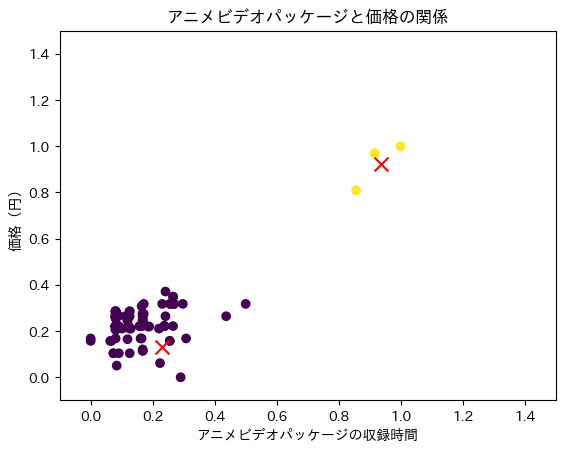

In [ ]:
#データの前処理
df = pd.DataFrame(json_load["@graph"])
df = df[['materialExtent',"price",'label',"publisher"]]
df = df.dropna(how="any")
df=df[df['publisher'].str.contains("バンダイビジュアル")]

#テキストデータから特徴量を抽出する処理
df['price'] = df['price'].str.extract(r'(\d+)', expand=False) # 一番最初にマッチする数字列のみを抽出
df['long']=df['materialExtent'].str.extract(r'(\d+)分', expand=False)

#欠損値処理
df=df.dropna(how='any')
df['price']=df['price'].astype(int)
df['long']=df['long'].astype(int)
cluster_df = df[["price",'long']]

#データの正規化
for column in cluster_df.columns:
  normalized_data = (cluster_df[column] - cluster_df[column].min()) / (cluster_df[column].max() - cluster_df[column].min())
  cluster_df[column] = normalized_data

# 2つのクラスタに分ける
kmeans = KMeans(n_clusters=2)

#k-meansクラスタリングのフィッティング
kmeans.fit(cluster_df)

#クラスタリング結果の取得
labels = kmeans.labels_  # 各データ点のクラスター割り当て結果
centroids = kmeans.cluster_centers_  # 各クラスターの中心点

#クラスタリング結果の可視化
fig, ax = plt.subplots(dpi=100)
plt.scatter(cluster_df["long"], cluster_df["price"], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=100)
ax.set_xlim(-0.1, 1.5)
ax.set_ylim(-0.1, 1.5)
ax.set_title('アニメビデオパッケージと価格の関係')
ax.set_xlabel('アニメビデオパッケージの収録時間')
ax.set_ylabel('価格（円）')
plt.show()


## ハイパーパラメータの決定
モデルにおいて，学習の過程で決定するパラメータ（例えばニューラルネットワークモデルの重み係数）のほかに，学習よりも前に決定しておかなければならないパラメータ（例えばkmeans法におけるクラスタ数）が存在する．これをハイパーパラメータと呼ぶ．

上の例ではハイパーパラメータをK=2と先に決定してしまっていたが，[メディア芸術データベースのデータ](https://github.com/mediaarts-db/dataset)を利用して，データを元に適切にハイパーパラメータの決定を行う手法のサンプルコードを見ていこう．


### エルボー法
今回はエルボー法という手法を用いてクラスタ数を決定する．
エルボー法とは，K個のクラスタに分けたときのSSE（クラスタ内誤差平方和）をプロットし，その値の減り方がガクッと落ちた時（ひじのように曲がっているとき）のクラスタ数を利用するという手法になる．
実際に図を書いてみよう．

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

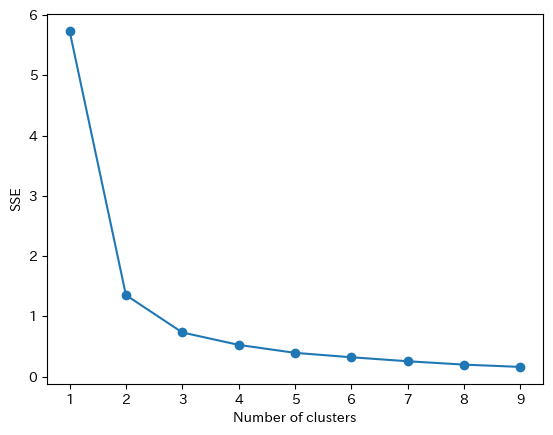

In [ ]:
distortions = [] # 各クラスタ数におけるSSE（クラスタ内誤差平方和）を保存しておくリスト

for i  in range(1,10):                # 1~9クラスタまでのSSEを一気に計算
    km = KMeans(n_clusters=i)
    km.fit(cluster_df)
    distortions.append(km.inertia_)   # SSEを取得し，リストに追加

# プロット
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

上の図より，クラスタ数は2-3個くらいが適切そうだということがわかる．

### プロットして比較
実際に，K＝8としてプロットしたものを，上でプロットしたK=2のものと比較してみよう．

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


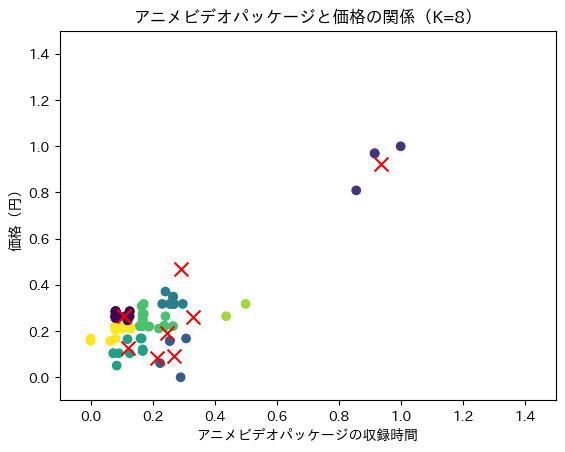

In [ ]:
#ハイパーパラメータクラスタ数を8

kmeans = KMeans(n_clusters=8)
#k-meansクラスタリングのフィッティング
kmeans.fit(cluster_df)

#クラスタリング結果の取得
labels = kmeans.labels_  # 各データ点のクラスター割り当て結果
centroids = kmeans.cluster_centers_  # 各クラスターの中心点
#クラスタリング結果の可視化
fig, ax = plt.subplots(dpi=100)
plt.scatter(cluster_df["long"], cluster_df["price"], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=100)
ax.set_xlim(-0.1, 1.5)
ax.set_ylim(-0.1, 1.5)
ax.set_title('アニメビデオパッケージと価格の関係（K=8）')
ax.set_xlabel('アニメビデオパッケージの収録時間')
ax.set_ylabel('価格（円）')
plt.show()

見比べてみても，K＝2の方が良さそうな結果になっている．